Goal:
Explore Covid 19 PCR Tests & Confirmed cases from Allegheny county,PA and find if there is any correlation betwen them

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import seaborn as sns
from matplotlib.axis import Axis  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import os
ospath = os.path.abspath("__file__")
currentDir = os.path.dirname(ospath)
data_path = currentDir + '\\..\\data\\'
result_path =currentDir + '\\..\\result\\'

os.makedirs(os.path.dirname(data_path), exist_ok=True) 
os.makedirs(os.path.dirname(result_path), exist_ok=True) 

print("data_path:", data_path)
print("result_path:", result_path)

fontsize = 10

data_path: C:\UW\512\Project\code\..\data\
result_path: C:\UW\512\Project\code\..\result\


In [3]:
# Ger mask usage data
MaskUseByCounty = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv', sep=',')
MaskUseByCounty.to_csv( data_path + 'mask-use-by-county.csv', sep=',', index = False, header = True)
Allegheny_MaskUseByCounty = MaskUseByCounty[MaskUseByCounty["COUNTYFP"] == 42003]
Allegheny_MaskUseByCounty.head(2)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2245,42003,0.017,0.022,0.035,0.165,0.761


In [6]:
Allegheny_MaskMandate = pd.read_csv(data_path + 'Allegheny_U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv',sep=',')
Allegheny_MaskMandate = Allegheny_MaskMandate[Allegheny_MaskMandate["Face_Masks_Required_in_Public"] == "Yes"]
Allegheny_MaskMandate['date'] = pd.to_datetime(Allegheny_MaskMandate['date'], format='%m/%d/%Y')
Allegheny_MaskMandate.head(2)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
9,PA,Allegheny County,42,3,2020-04-19,1,Yes,Official,https://www.governor.pa.gov/wp-content/uploads...,"Pa. Health Order (Apr. 15, 2020)"
10,PA,Allegheny County,42,3,2020-04-20,1,Yes,Official,https://www.governor.pa.gov/wp-content/uploads...,"Pa. Health Order (Apr. 15, 2020)"


In [9]:
# Get Confirmed cases
RAW_us_confirmed_cases = pd.read_csv(data_path + 'RAW_us_confirmed_cases.csv',sep=',')
Allegheny_RAW_us_confirmed_cases = RAW_us_confirmed_cases[(RAW_us_confirmed_cases["Province_State"] == "Pennsylvania") & (RAW_us_confirmed_cases["Admin2"] == "Allegheny")].head(2)
Allegheny_RAW_us_confirmed_cases.head(2)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21
2332,Pennsylvania,Allegheny,84042003,US,USA,840,42003.0,US,40.468099,-79.981677,...,128478,128955,129285,129734,129997,130274,130624,131032,131420,131892


In [10]:
# Pivot data to get one row per day
Allegheny_us_confirmed_cases = Allegheny_RAW_us_confirmed_cases.melt(id_vars=["Province_State","Admin2","UID","iso2","iso3","code3","FIPS","Country_Region","Lat","Long_", "Combined_Key"], 
        var_name="date", 
        value_name="ConfirmedCases")
Allegheny_us_confirmed_cases['date'] = pd.to_datetime(Allegheny_us_confirmed_cases['date'], format='%m/%d/%y')
Allegheny_us_confirmed_cases.head(2)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,ConfirmedCases
0,Pennsylvania,Allegheny,84042003,US,USA,840,42003.0,US,40.468099,-79.981677,"Allegheny, Pennsylvania, US",2020-01-22,0
1,Pennsylvania,Allegheny,84042003,US,USA,840,42003.0,US,40.468099,-79.981677,"Allegheny, Pennsylvania, US",2020-01-23,0


In [12]:
df_Allegheny_confirmedCases = Allegheny_us_confirmed_cases[["date","ConfirmedCases"]]
df_Allegheny_confirmedCases.loc[:,'DailyCases'] = df_Allegheny_confirmedCases['ConfirmedCases'].diff().fillna(df_Allegheny_confirmedCases['ConfirmedCases'])
df_Allegheny_confirmedCases.loc[:,'DailyCases_7DayMovingAvg'] = df_Allegheny_confirmedCases.DailyCases.rolling(7, min_periods=1,center=True).mean().astype('int64')

df_Allegheny_MaskMandate = Allegheny_MaskMandate[["date", "Face_Masks_Required_in_Public"]]
df_Allegheny_MaskMandate.Face_Masks_Required_in_Public.replace(('Yes', 'no'), (True, False) , inplace=True)
df_Allegheny_MaskMandate.loc[:,'Face_Masks_Required_in_Public'] = df_Allegheny_MaskMandate['Face_Masks_Required_in_Public'].astype(bool)

In [13]:
# Combine all data sets 
df_final = df_Allegheny_confirmedCases.join(df_Allegheny_MaskMandate.set_index('date'), on='date', how ='left').fillna(0)
df_final["Population"] = 1250578
df_final["InfectionRate"] = df_final["DailyCases_7DayMovingAvg"]/df_final["Population"]
df_final.dtypes

date                             datetime64[ns]
ConfirmedCases                            int64
DailyCases                              float64
DailyCases_7DayMovingAvg                  int64
Face_Masks_Required_in_Public            object
Population                                int64
InfectionRate                           float64
dtype: object

In [14]:
df_final.head(2)

,date,ConfirmedCases,DailyCases,DailyCases_7DayMovingAvg,Face_Masks_Required_in_Public,Population,InfectionRate
0,2020-01-22,0,0.0,0,0,1250578,0.0
1,2020-01-23,0,0.0,0,0,1250578,0.0


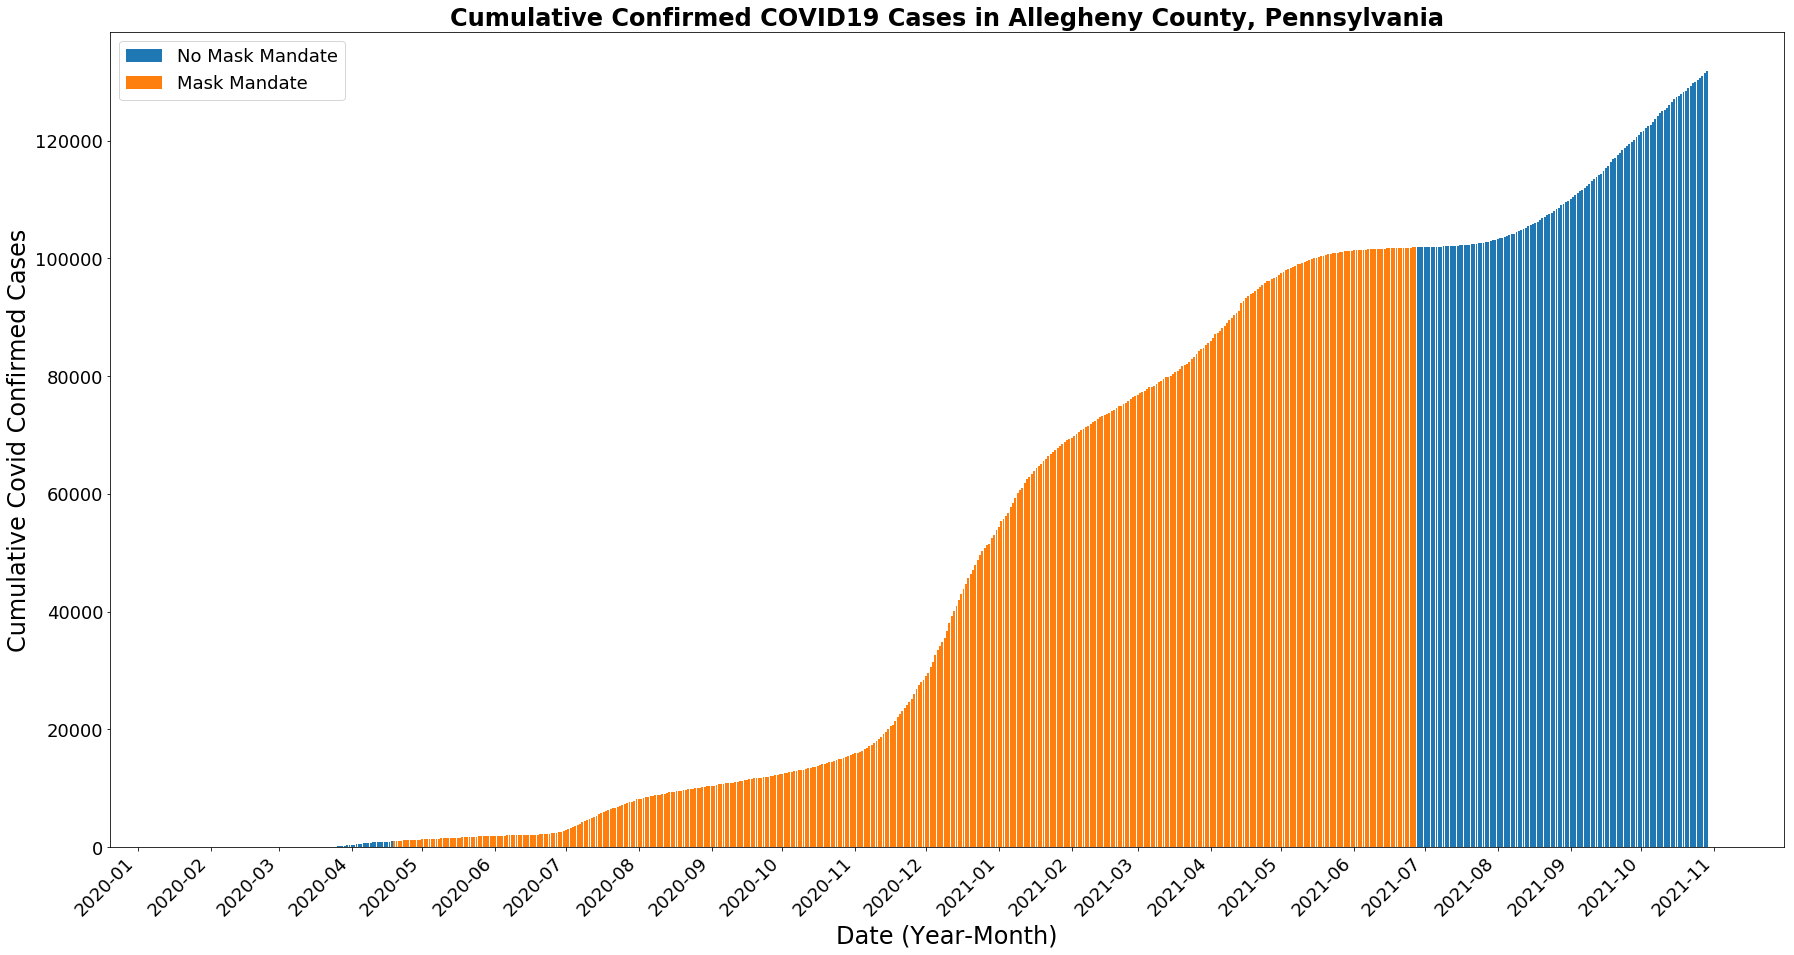

In [16]:
#Plot Cumulative confirmed cases
plt.figure(figsize=(30,15))
plt.bar(df_final['date'],df_final['ConfirmedCases'],label= "No Mask Mandate")
#plt.legend("No Mask Mandate")
plt.bar(df_final[df_final['Face_Masks_Required_in_Public'] == 1]['date'],df_final[df_final['Face_Masks_Required_in_Public'] == 1]['ConfirmedCases'],label= "Mask Mandate")
#plt.legend("Mask Mandate")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45,ha='right',fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title("Cumulative Confirmed COVID19 Cases in Allegheny County, Pennsylvania",fontweight="bold",fontsize=24)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.ylabel("Cumulative Covid Confirmed Cases",fontsize=24);
plt.show()

Covid cases data set has cumulative numbers, so we have to calculate daily volume using cumulative number for our analysis

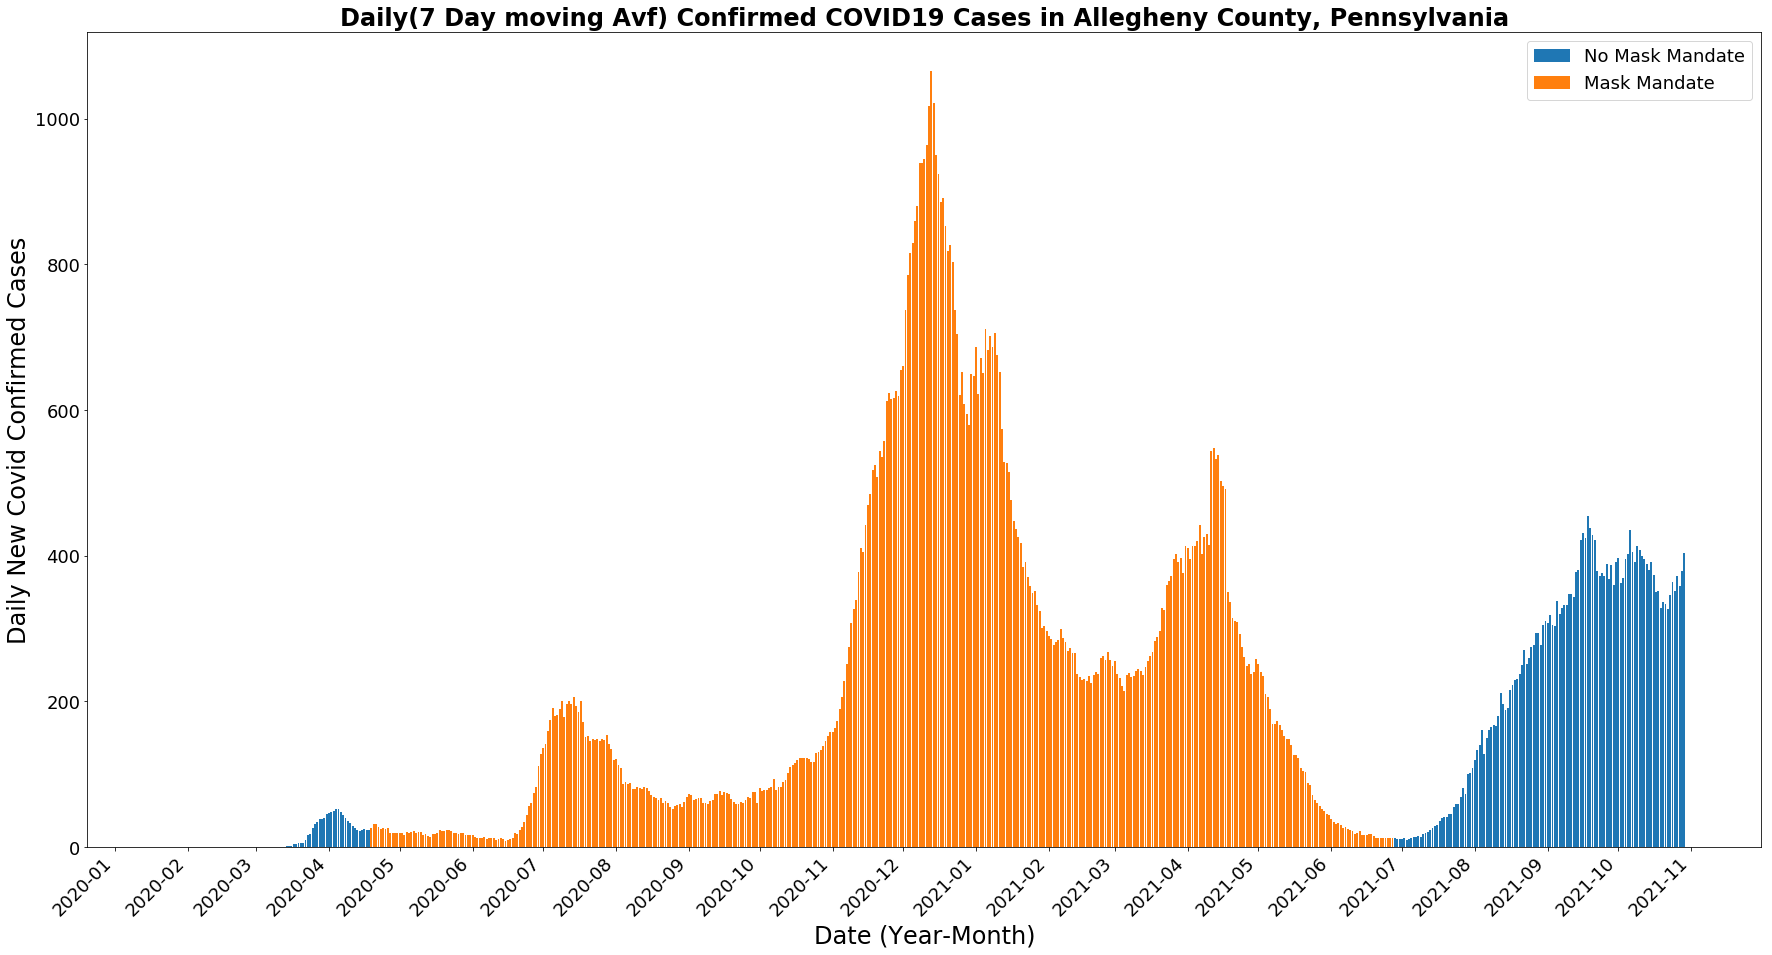

In [17]:
#Plot daily confirmed cases (7 day moving avg) and show mask mandate period
plt.figure(figsize=(30,15))
plt.bar(df_final['date'],df_final['DailyCases_7DayMovingAvg'],label= "No Mask Mandate")
#plt.legend("No Mask Mandate")
plt.bar(df_final[df_final['Face_Masks_Required_in_Public'] == 1]['date'],df_final[df_final['Face_Masks_Required_in_Public'] == 1]['DailyCases_7DayMovingAvg'],label= "Mask Mandate")
#plt.legend("Mask Mandate")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45,ha='right',fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title("Daily(7 Day moving Avf) Confirmed COVID19 Cases in Allegheny County, Pennsylvania",fontweight="bold",fontsize=24)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.ylabel("Daily New Covid Confirmed Cases",fontsize=24);
plt.show()

Based on below charts for daily (7day moving avg) covid cases & daily infection rate change for Allegheny County, Pennsylvania. Looking at daily confirmed cases chart masking policy impact is less, in fact daily cases spiked when masking mandate is on. Based on mask compliance survey 76% of people always followed mask mandate guidelines, but still number of cases increased significantly when the mask is mandated. 

There might be some delay in data collection on weekend/holiday and report time, so we need to calculate 7 day moving avaerage to smoothen the data issues.

In [18]:
# Get PCRTest data
PCRTestData = pd.read_csv(data_path + 'COVID-19_PCR_Test_Counts_March_2020_-_Current_Statewide_Health.csv',sep=',')
PCRTestData['date'] = pd.to_datetime(PCRTestData['Date'], format='%m/%d/%Y')
PCRTestData['NewPCRTests'] = PCRTestData['New PCR Tests']

PCRTestData.loc[:,'PCRTests_7DayMovingAvg'] = PCRTestData.NewPCRTests.rolling(7, min_periods=1,center=False).mean().astype('int64')

PCRTestData = PCRTestData[['date','New PCR Tests','PCRTests_7DayMovingAvg']] 

PCRTestData.head(5)

,date,New PCR Tests,PCRTests_7DayMovingAvg
0,2020-03-01,0,0
1,2020-03-02,0,0
2,2020-03-03,5,1
3,2020-03-04,2,1
4,2020-03-05,4,2


In [19]:
# Get Covid19 death data
Death_Data = pd.read_csv(data_path + 'COVID-19_Aggregate_Death_Data_Current_Daily_County_Health.csv',sep=',')
Death_Data = Death_Data[Death_Data["County Name"] == "Allegheny"]
Death_Data['date'] = pd.to_datetime(Death_Data['Date of Death'], format='%m/%d/%Y')
Death_Data['Deaths_7DayMovingAvg'] = Death_Data['7-day Average New Deaths']
Death_Data = Death_Data[['date','Deaths_7DayMovingAvg']] 
Death_Data.head(2)

,date,Deaths_7DayMovingAvg
0,2021-06-13,1.4
1,2021-08-05,0.7


Combine all data sets - Covid confirmed cases, PCR Test & death data

In [20]:
df_final = df_final.join(PCRTestData.set_index('date'), on='date', how ='left') \
    .join(Death_Data.set_index('date'), on='date', how ='left') \
    .fillna(0)
df_final = df_final[df_final["date"] >= "2020-03-20"]
df_final = df_final[df_final["date"] < "2021-11-01"]
df_final["ConfirmedCaseRate"] = df_final['DailyCases_7DayMovingAvg']/df_final['New PCR Tests']

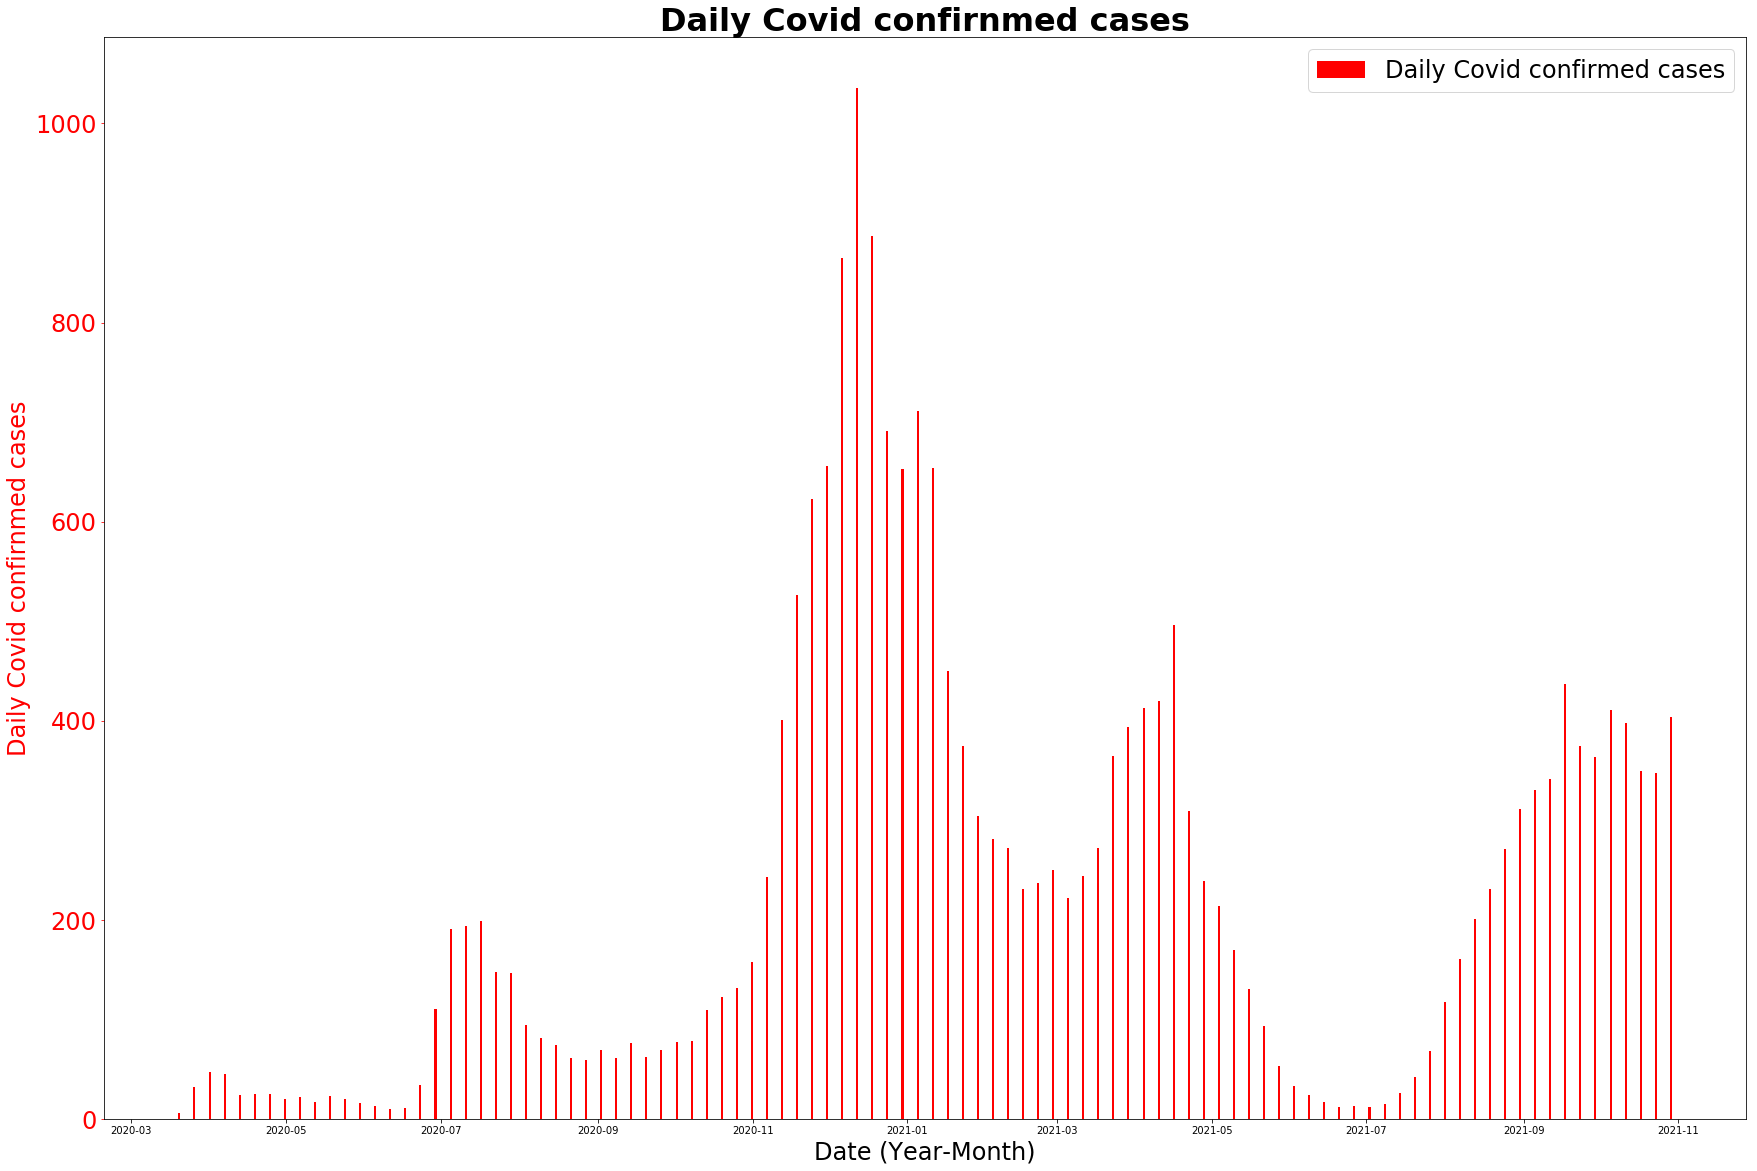

In [21]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(24,16))

date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['DailyCases_7DayMovingAvg'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)
p1 = ax1.bar(date_num_smooth2, value_np_smooth,label= "'Daily Covid confirnmed cases", color = "r")


ax1.set_xlabel("Date (Year-Month)",fontsize=24)
ax1.set_ylabel('Daily Covid confirnmed cases', color='r', fontsize=24)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")

fig.tight_layout()
plt.yticks(fontsize=24)
plt.title("Daily Covid confirnmed cases",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.legend([p1],["Daily Covid confirmed cases"],fontsize=24)
plt.show()

Above chart shows daily covid confirmed cases (7 day moving Avg.)

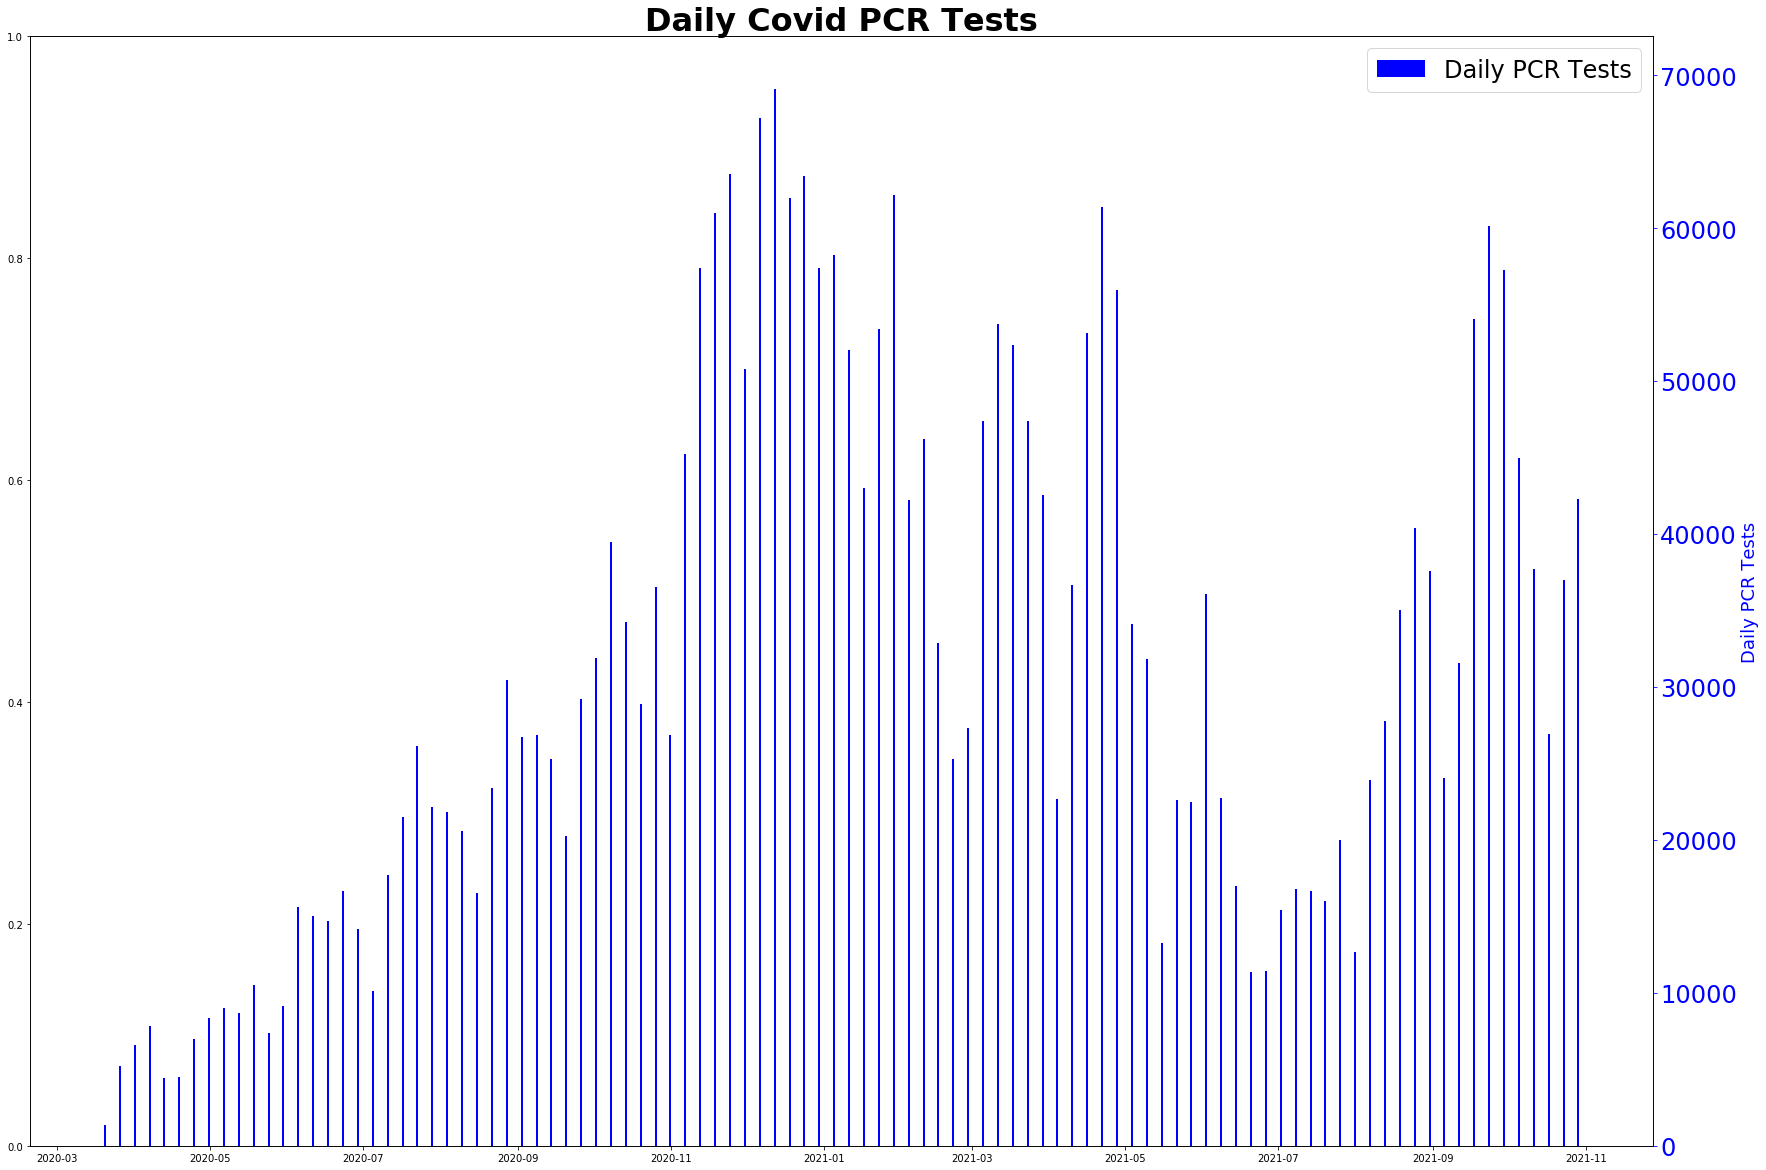

In [22]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(24,16))

#create data
date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['New PCR Tests'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)

ax2 = ax1.twinx()
p2 = ax2.bar(date_num_smooth2, value_np_smooth, label= "PCR Tests",color = "b")
ax2.set_ylabel('Daily PCR Tests', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()

plt.xticks(rotation=45,ha='right',fontsize=24)
plt.yticks(fontsize=24)
plt.title("Daily Covid PCR Tests",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.legend([p2],["Daily PCR Tests"],fontsize=24)
plt.show()

Above plot shows daily PCR Test volume.

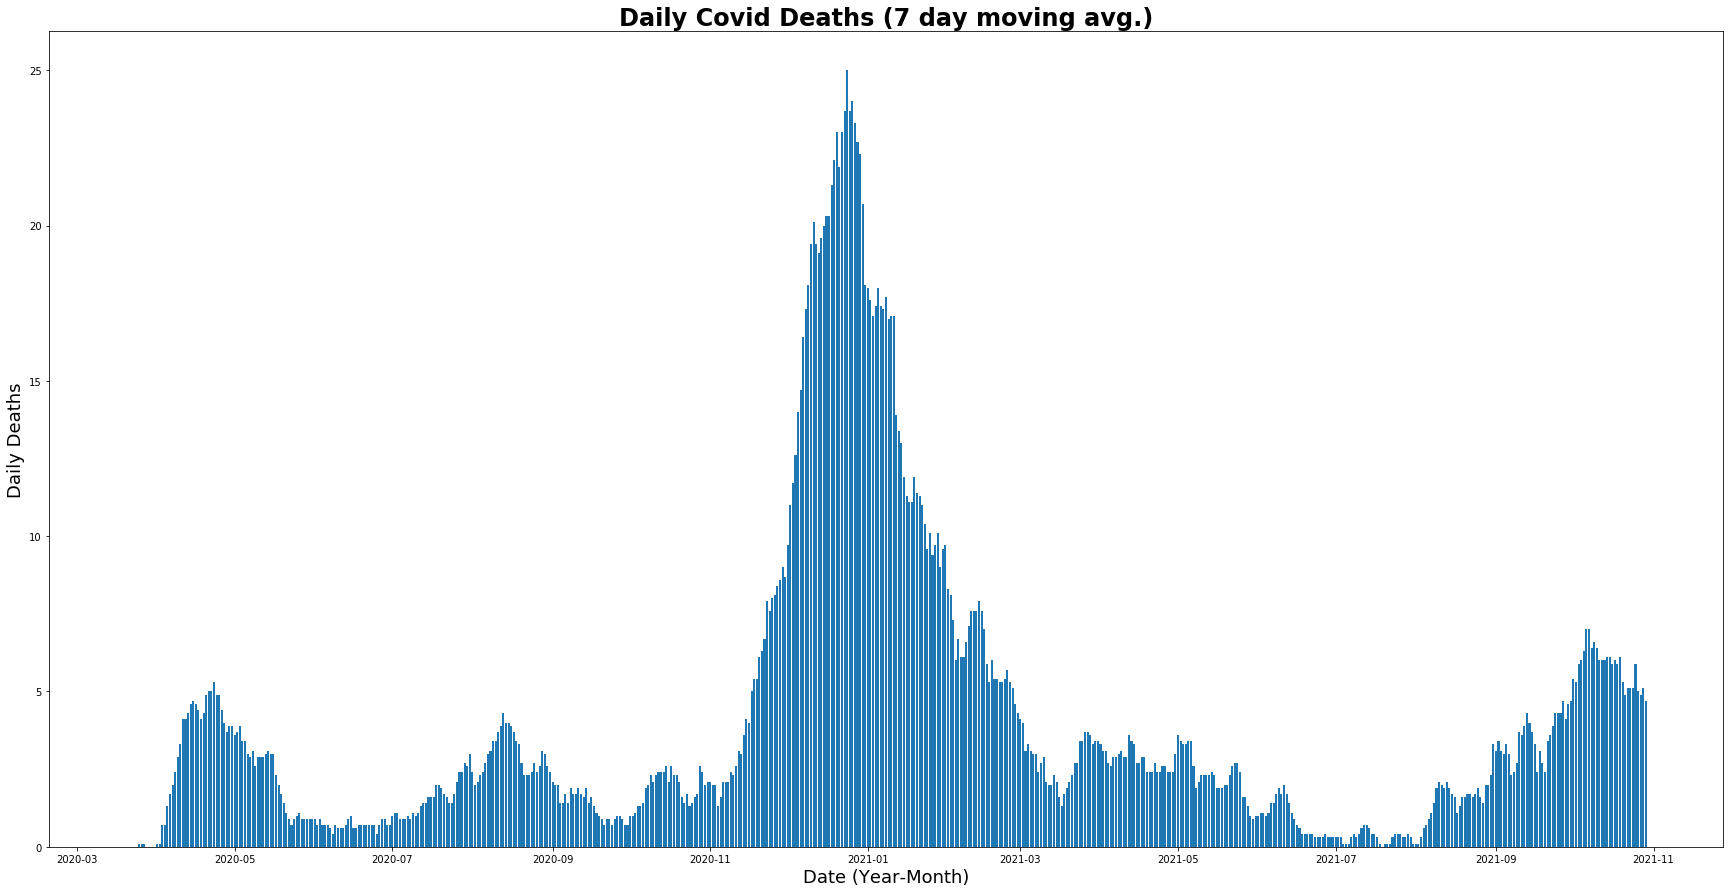

In [23]:
plt.figure(figsize=(30,15))
plt.bar(df_final['date'],df_final['Deaths_7DayMovingAvg'],label= "Daily Deaths")
plt.title("Daily Covid Deaths (7 day moving avg.)",fontweight="bold",fontsize=24)
plt.xlabel("Date (Year-Month)",fontsize=18)
plt.ylabel("Daily Deaths",fontsize=18);

plt.show()

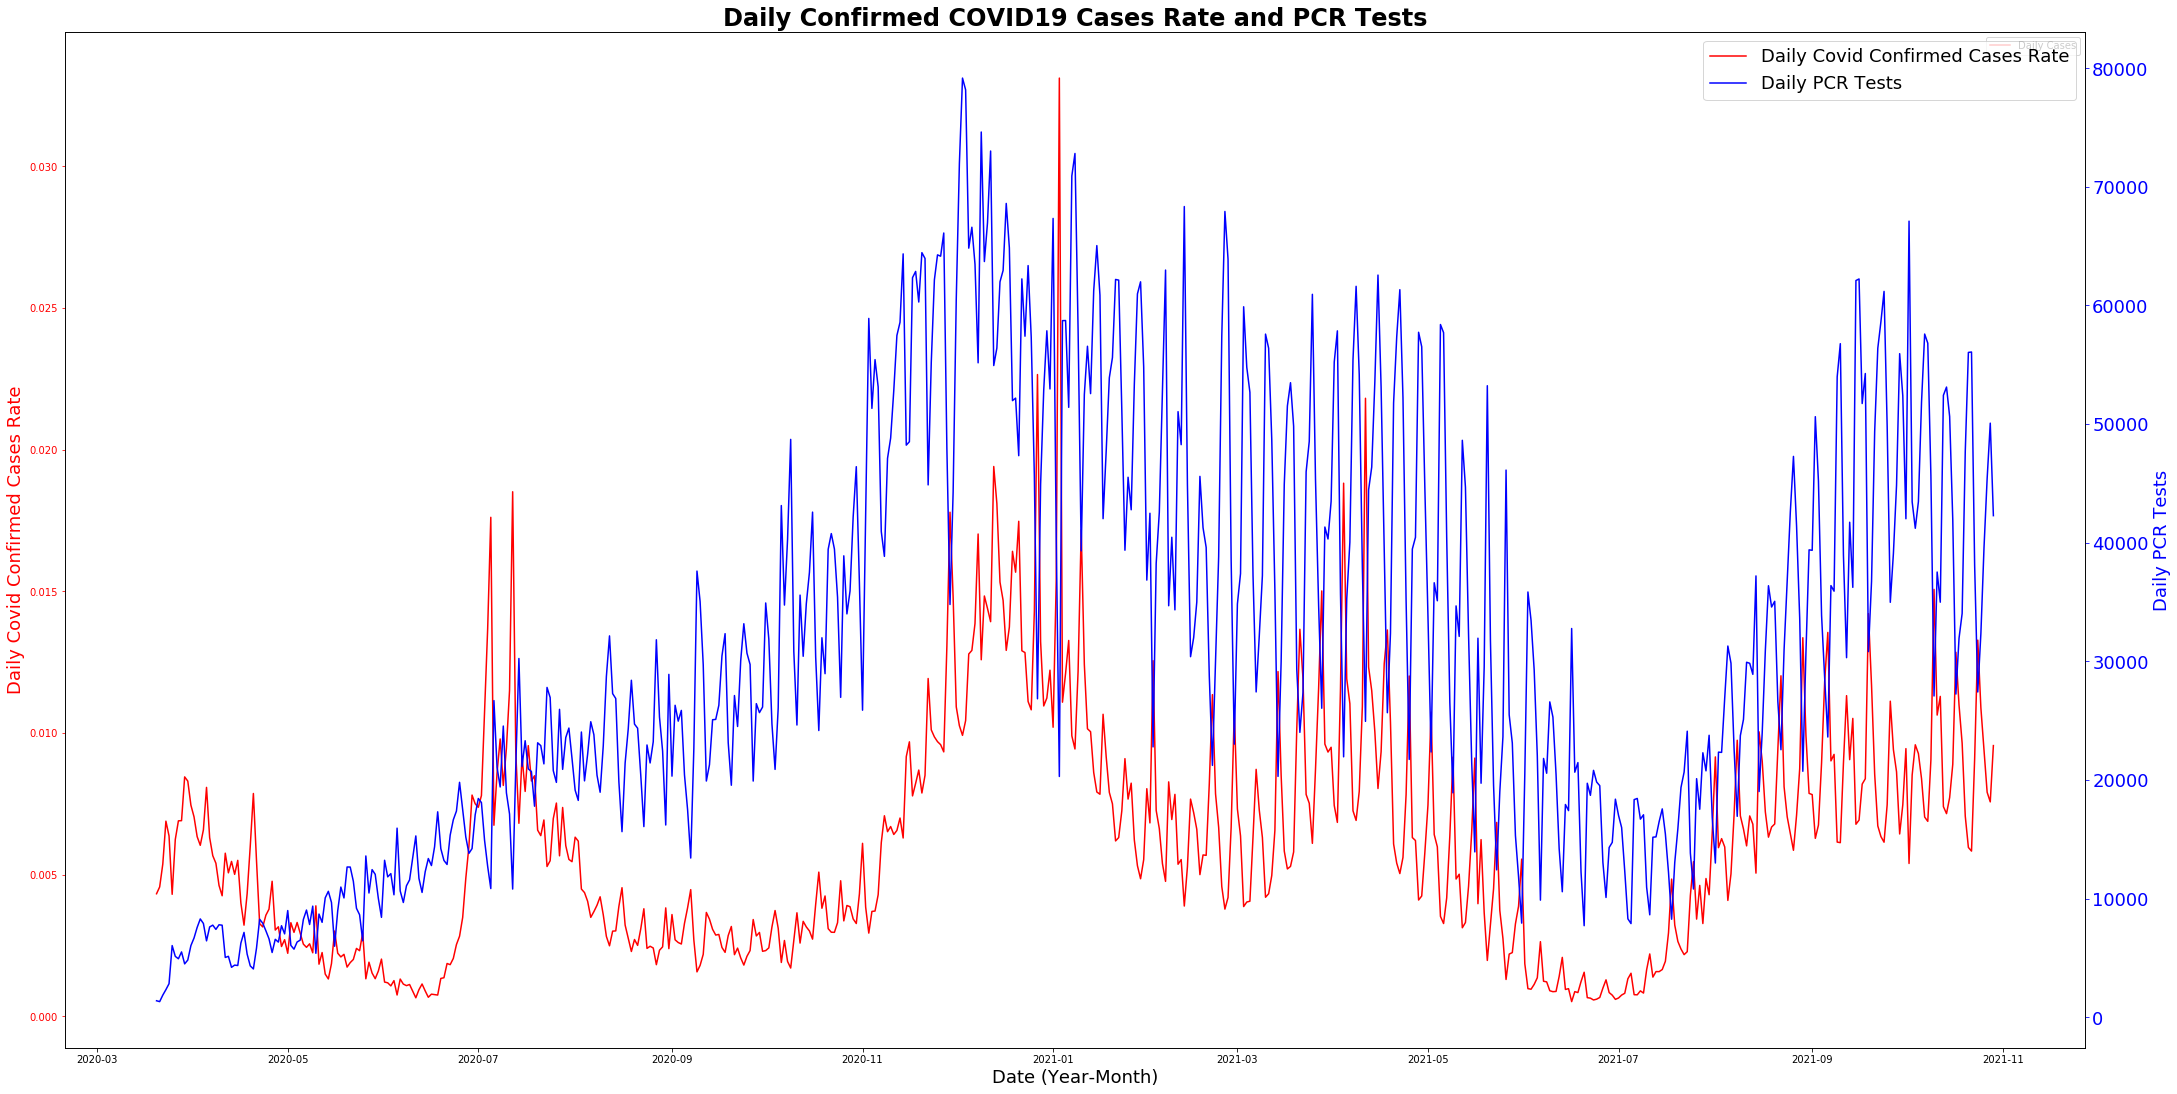

In [24]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(30,15))


p1, = ax1.plot(df_final['date'],df_final['ConfirmedCaseRate'],label= "Daily Cases", color = "r")
ax1.set_xlabel("Date (Year-Month)",fontsize=18)
ax1.set_ylabel('Daily Covid Confirmed Cases Rate', color='r', fontsize=18)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")

# print
ax2 = ax1.twinx()
p2, = ax2.plot(df_final['date'], df_final['New PCR Tests'],label= "Daily PCR Tests", color = "b")
ax2.set_ylabel('Daily PCR Tests', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()
plt.xticks(rotation=45,ha='right',fontsize=18)
plt.yticks(fontsize=18)
plt.legend([p1,p2],["Daily Covid Confirmed Cases Rate", "Daily PCR Tests"],fontsize=18)
plt.title("Daily Confirmed COVID19 Cases Rate and PCR Tests",fontweight="bold",fontsize=24)
plt.xlabel("Date (Year-Month)",fontsize=12)
plt.show()

Above chart shows daily confirmed Covid cases and PCR tests. Both lines are included in same chart so that we can observe the trend. Due to too many points it is hard to see trend, so let’s check by smoothing the curves.

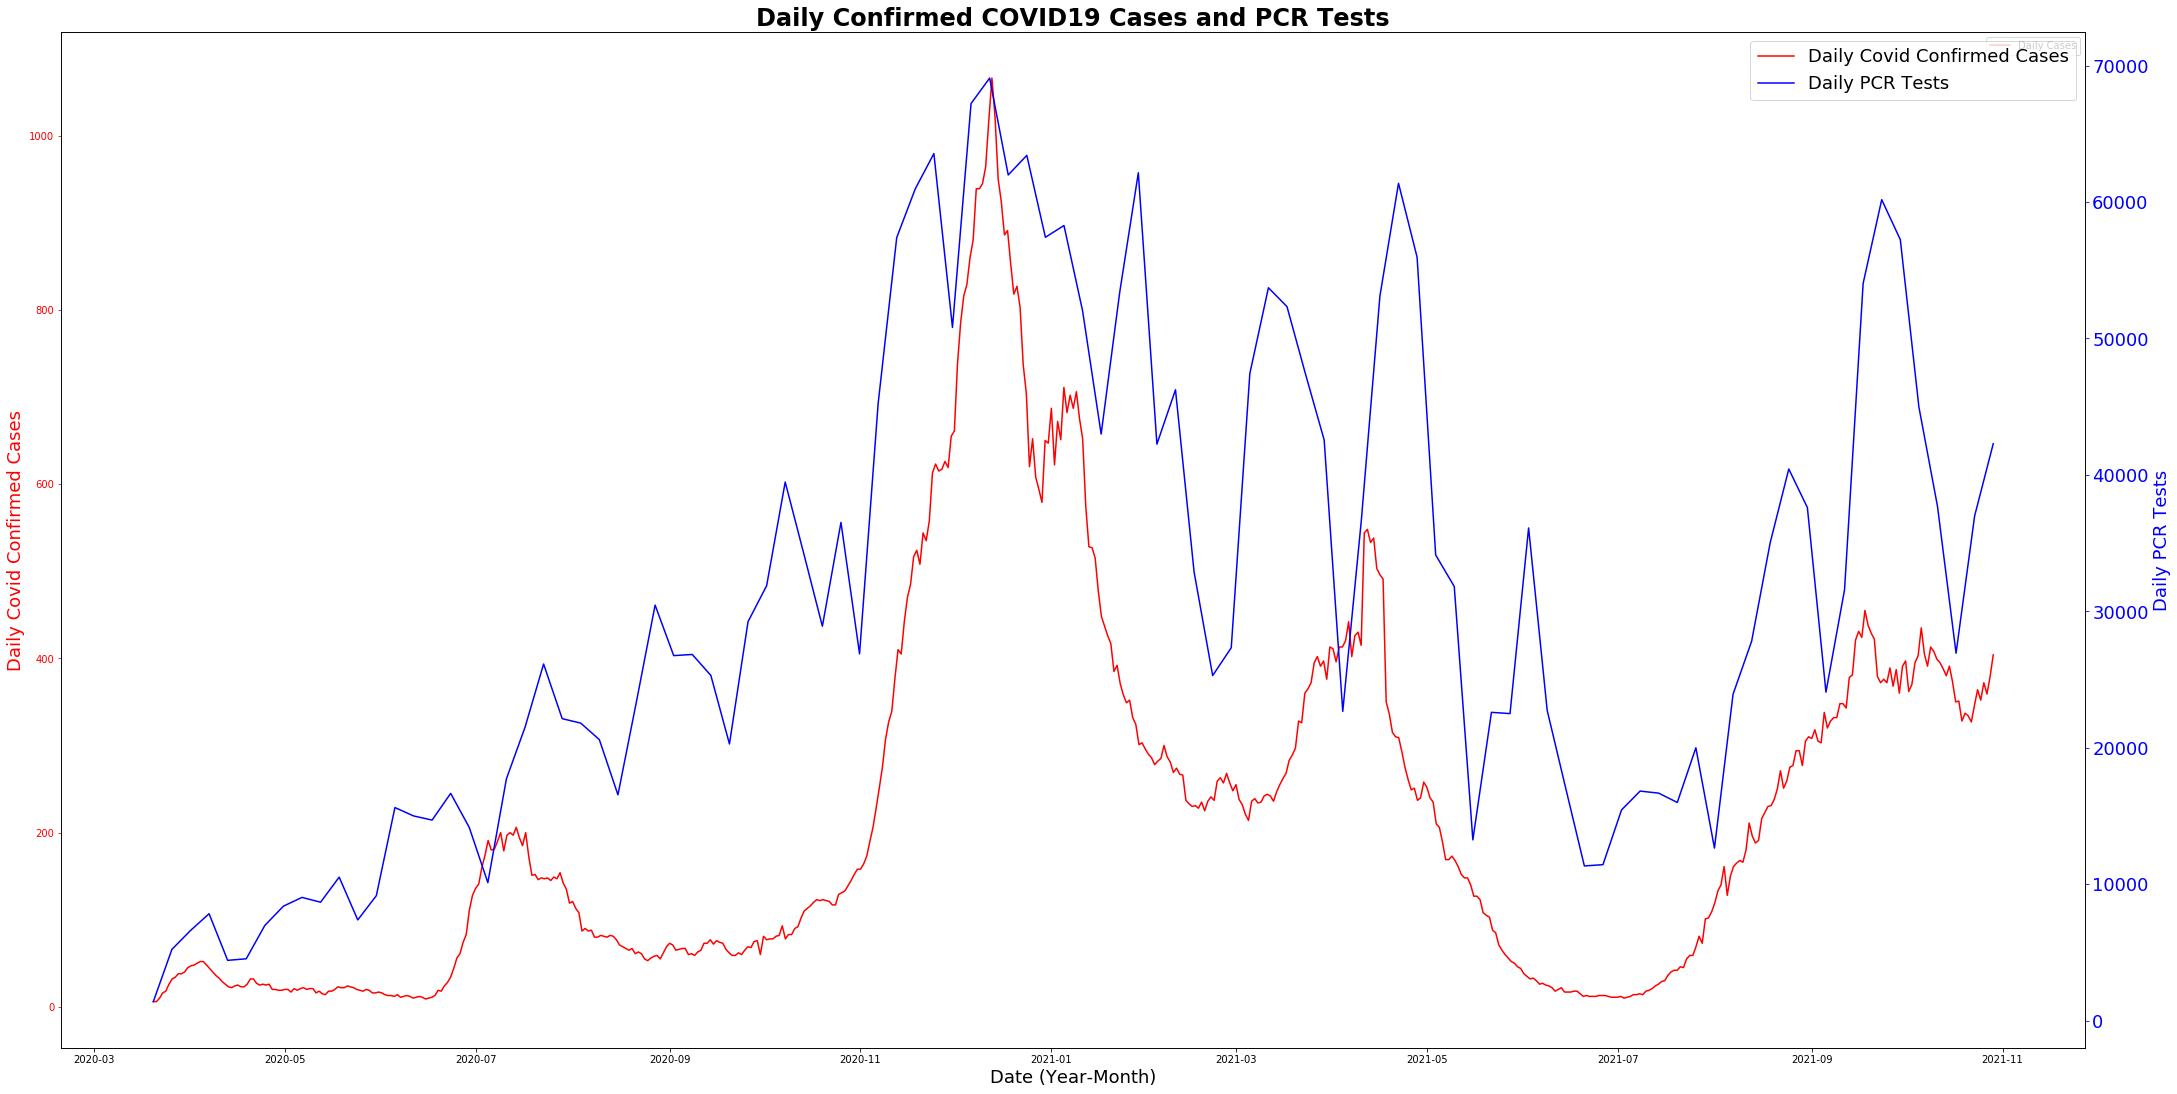

In [25]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(30,15))


p1, = ax1.plot(df_final['date'],df_final['DailyCases_7DayMovingAvg'],label= "Daily Cases", color = "r")
#ax1.set_xlabel('Date',fontsize=18)
ax1.set_xlabel("Date (Year-Month)",fontsize=18)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Daily Covid Confirmed Cases', color='r', fontsize=18)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")
#create data
date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['New PCR Tests']))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)

ax2 = ax1.twinx()
p2, = ax2.plot(date_num_smooth2, value_np_smooth,label= "Daily PCR Tests", color = "b")
ax2.set_ylabel('Daily PCR Tests', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()
plt.xticks(rotation=45,ha='right',fontsize=18)
plt.yticks(fontsize=18)
plt.legend([p1,p2],["Daily Covid Confirmed Cases", "Daily PCR Tests"],fontsize=18)
plt.title("Daily Confirmed COVID19 Cases and PCR Tests",fontweight="bold",fontsize=24)
plt.xlabel("Date (Year-Month)",fontsize=12)
plt.show()

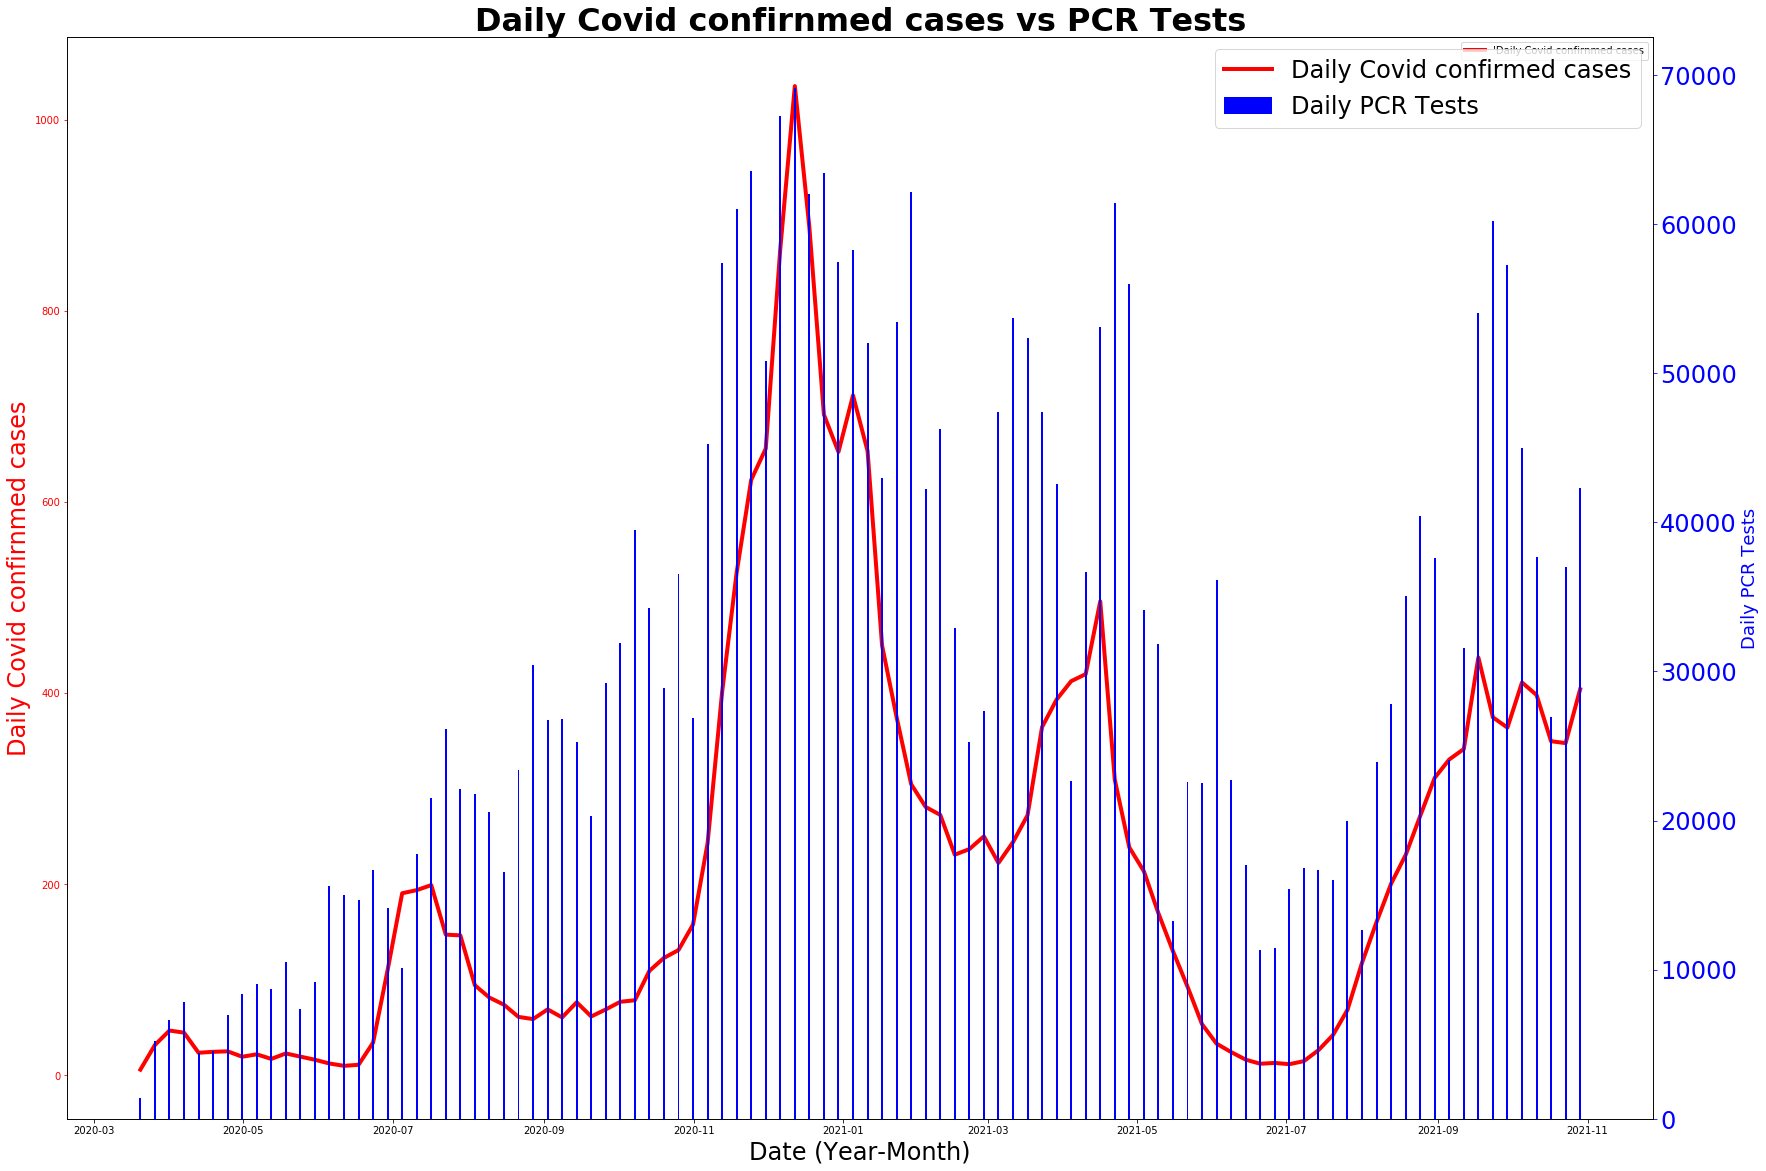

In [26]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(24,16))

date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['DailyCases_7DayMovingAvg'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)
p1, = ax1.plot(date_num_smooth2, value_np_smooth,label= "'Daily Covid confirnmed cases", color = "r",linewidth=4.0)
ax1.set_xlabel("Date (Year-Month)",fontsize=24)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Daily Covid confirnmed cases', color='r', fontsize=24)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")
#create data
date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['New PCR Tests'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)

ax2 = ax1.twinx()
p2 = ax2.bar(date_num_smooth2, value_np_smooth, label= "PCR Tests",color = "b")
ax2.set_ylabel('Daily PCR Tests', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()
plt.xticks(rotation=45,ha='right',fontsize=24)
plt.yticks(fontsize=24)
plt.title("Daily Covid confirnmed cases vs PCR Tests",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.legend([p1,p2],["Daily Covid confirmed cases", "Daily PCR Tests"],fontsize=24)
plt.show()

After smoothing curves, we can compare the two time series lines. Overall confirmed cases are up/down when tests are increased/decreased except at few intervals.

Lets look at correlation using stastical methods. I am using Person correlation & Spearmans correlation

Pearsons correlation: 0.789 and p-Value 0.000 
Spearmans correlation: 0.841 and p-Value 0.000 


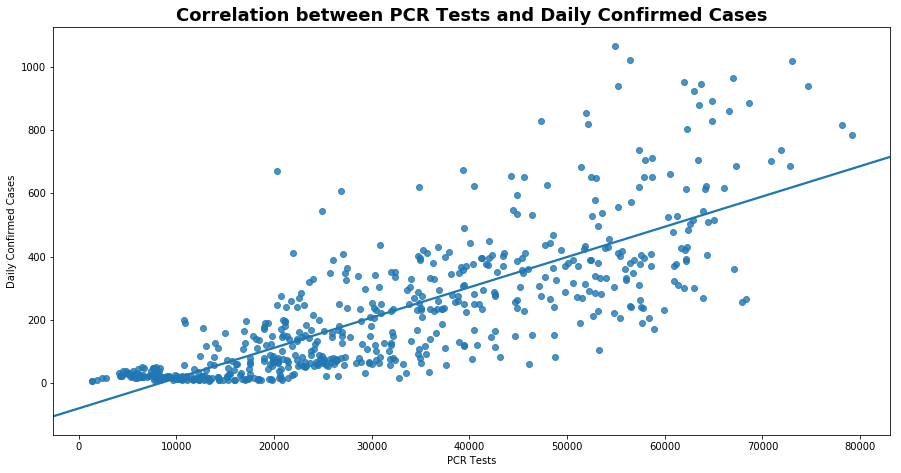

In [27]:
#create scatterplot with regression line

splot = sns.regplot( df_final['New PCR Tests'],df_final['DailyCases_7DayMovingAvg'], ci=None)
splot.figure.set_size_inches(15, 7.5)
splot.set_title('Correlation between PCR Tests and Daily Confirmed Cases',weight='bold').set_fontsize('18')
splot.set_ylabel('Daily Confirmed Cases')
splot.set_xlabel('PCR Tests')



covariance = np.cov(df_final['DailyCases_7DayMovingAvg'], df_final['New PCR Tests'])
#print(covariance)
from scipy.stats import pearsonr
corr, pv = pearsonr(df_final['DailyCases_7DayMovingAvg'], df_final['New PCR Tests'])
print('Pearsons correlation: %.3f and p-Value %.3f ' % ( corr, pv))

from scipy.stats import spearmanr
# calculate spearman's correlation
corr, pv = spearmanr(df_final['DailyCases_7DayMovingAvg'], df_final['New PCR Tests'])
print('Spearmans correlation: %.3f and p-Value %.3f ' % ( corr, pv))

Correlation coefficient is ~0.8  with p value ~0.000. That means there is strong positive correlation between PCR Tests and confirmed cases. And since p < 0.0005@, the tests is stastically significant.

Can we conclude that covid confirmed cases are up due to more tests? Is it right way to perform this analysis? Lets look at confirmed cases for 1000 tests across all days.

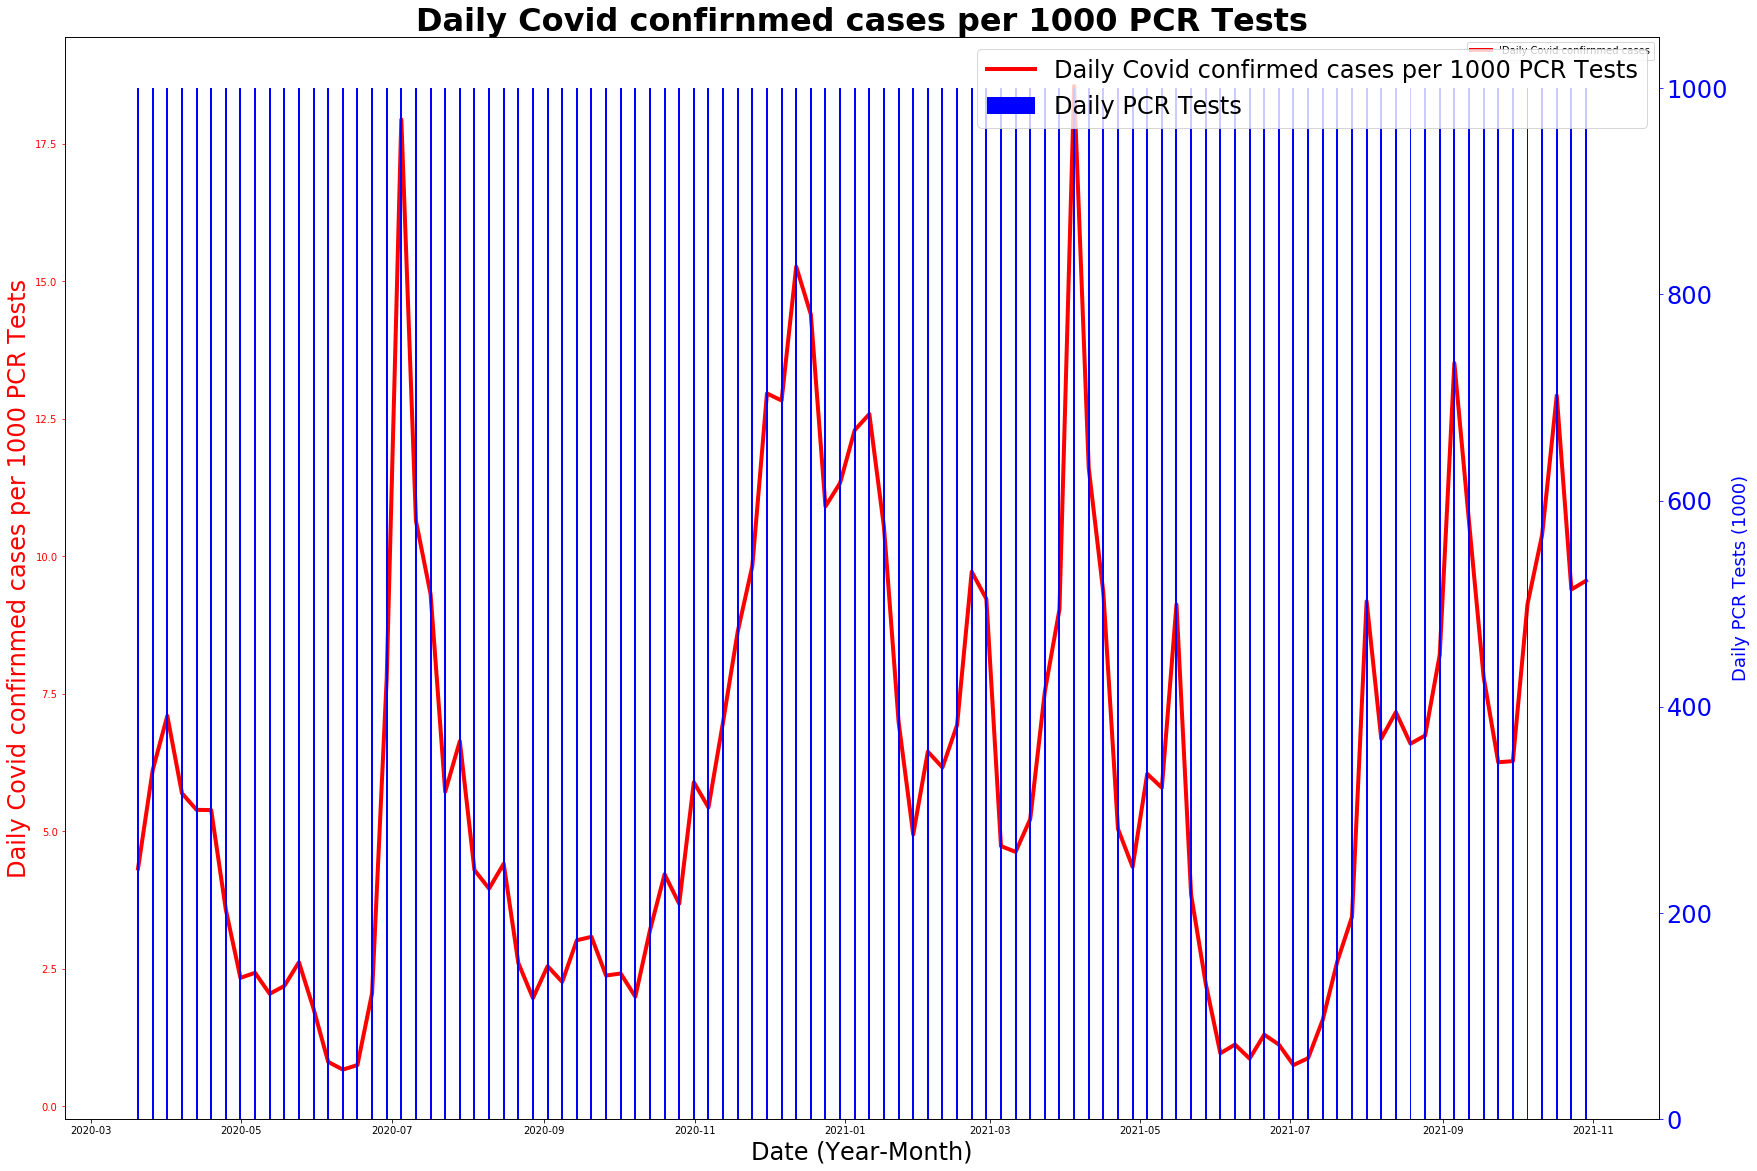

In [28]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(24,16))

date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['ConfirmedCaseRate'] * 1000 ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)
p1, = ax1.plot(date_num_smooth2, value_np_smooth,label= "'Daily Covid confirnmed cases", color = "r",linewidth=4.0)
ax1.set_xlabel("Date (Year-Month)",fontsize=24)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Daily Covid confirnmed cases per 1000 PCR Tests', color='r', fontsize=24)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")
#create data
date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['New PCR Tests']*0+1000 ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)

ax2 = ax1.twinx()
p2 = ax2.bar(date_num_smooth2, value_np_smooth, label= "PCR Tests",color = "b")
ax2.set_ylabel('Daily PCR Tests (1000)', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()

plt.xticks(rotation=45,ha='right',fontsize=24)
plt.yticks(fontsize=24)
plt.title("Daily Covid confirnmed cases per 1000 PCR Tests",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.legend([p1,p2],["Daily Covid confirmed cases per 1000 PCR Tests", "Daily PCR Tests"],fontsize=24)
plt.show()

whenw e fix number of tests (1000), we can observe confirmed cases are not constant/linear. It went up at certain intervals and down some times. So this chart shows there is no correlation between PCRtests and confirmed casesrate.

Lets check using stastical methods if there is relation between PCR tests and confirmed cases rate.

Pearsons correlation: 0.397 and p-Value 0.000 
Spearmans correlation: 0.467 and p-Value 0.000 


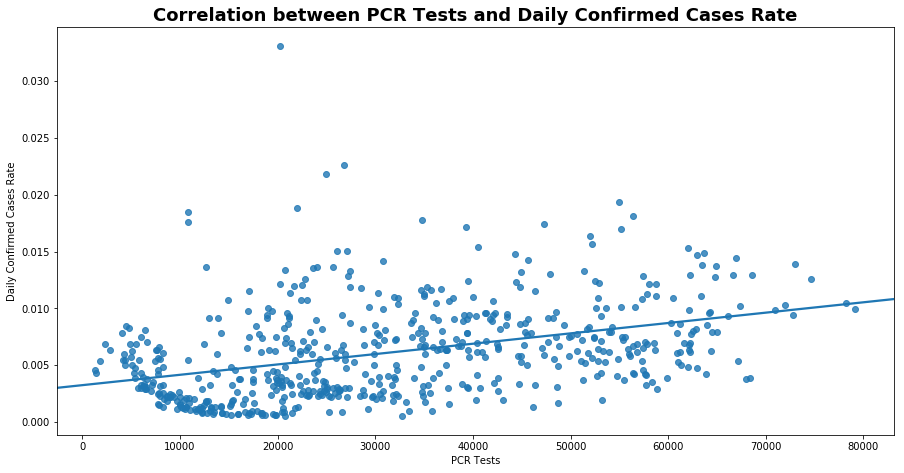

In [29]:
#create scatterplot with regression line
splot = sns.regplot( df_final['New PCR Tests'],df_final['ConfirmedCaseRate'], ci=None)
splot.figure.set_size_inches(15, 7.5)
splot.set_title('Correlation between PCR Tests and Daily Confirmed Cases Rate',weight='bold').set_fontsize('18')
splot.set_ylabel('Daily Confirmed Cases Rate')
splot.set_xlabel('PCR Tests')
#sns.despine()



covariance = np.cov(df_final['ConfirmedCaseRate'], df_final['New PCR Tests'])
#print(covariance)
from scipy.stats import pearsonr
corr, pv = pearsonr(df_final['ConfirmedCaseRate'], df_final['New PCR Tests'])
print('Pearsons correlation: %.3f and p-Value %.3f ' % ( corr, pv))

from scipy.stats import spearmanr
# calculate spearman's correlation
corr, pv = spearmanr(df_final['ConfirmedCaseRate'], df_final['New PCR Tests'])
print('Spearmans correlation: %.3f and p-Value %.3f ' % ( corr, pv))

Correlation coefficient is < ~0.5  with p value ~0.000. That means there is no strong correlation between PCR Tests and confirmed cases. And since p < 0.0005@, the tests is stastically significant.

Lets look at the death data and find if tests are increased due to people scared due to high death rate.

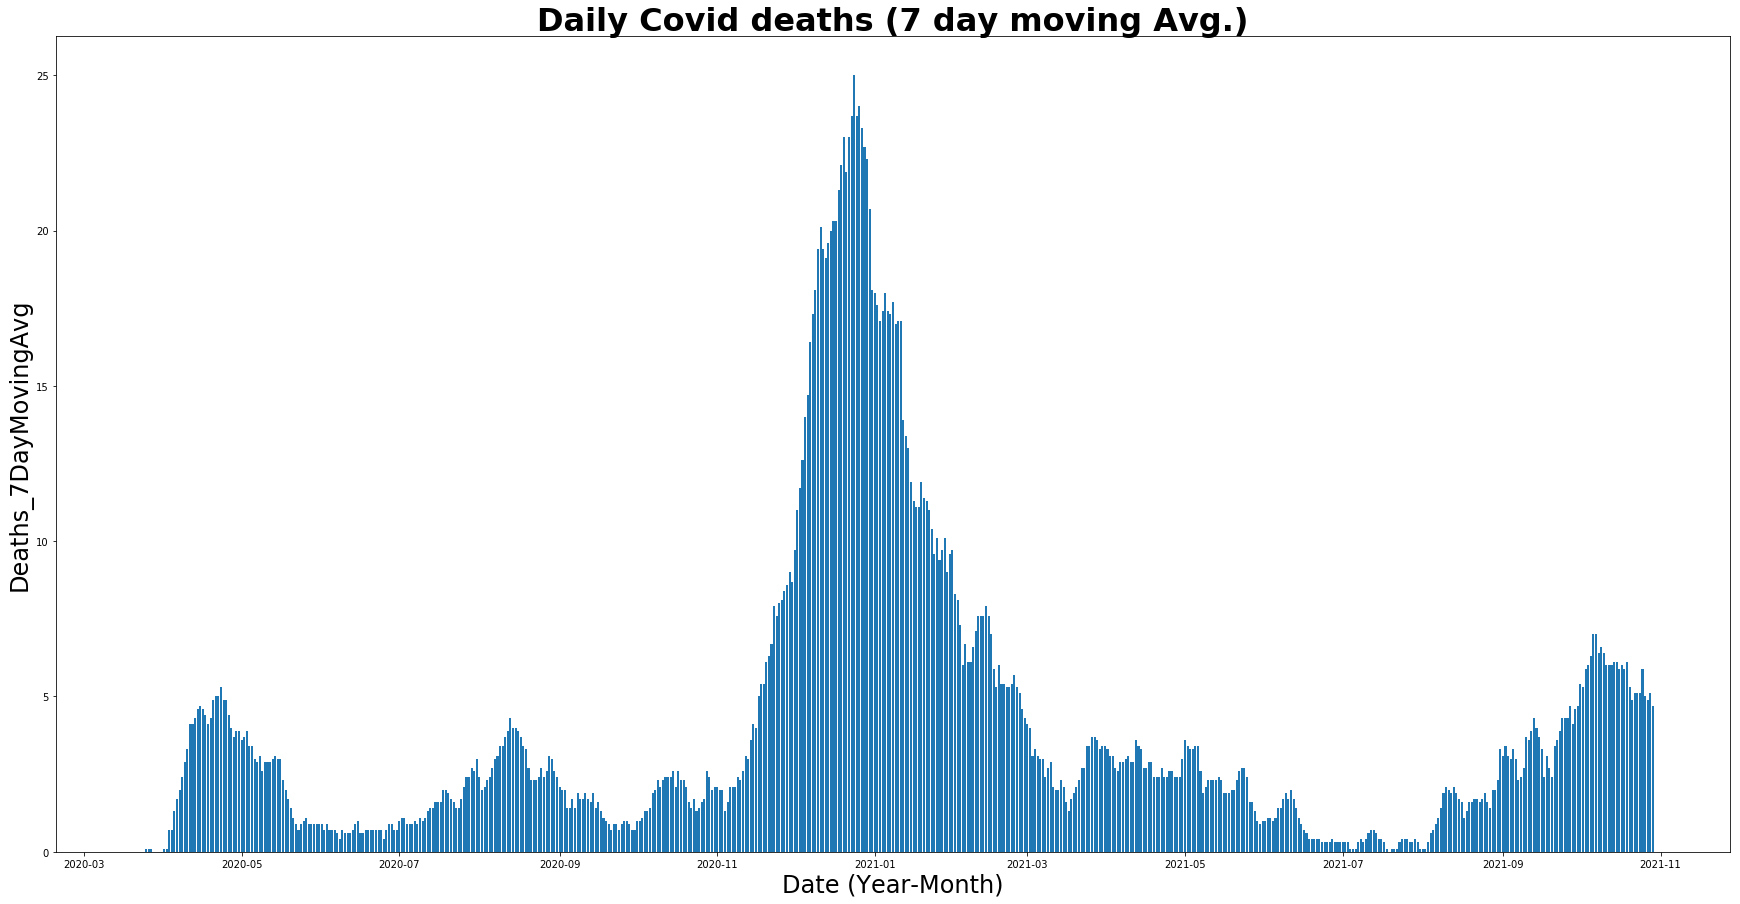

In [30]:
plt.figure(figsize=(30,15))
plt.bar(df_final['date'],df_final["Deaths_7DayMovingAvg"],label= "Deaths_7DayMovingAvg")
plt.title("Daily Covid deaths (7 day moving Avg.)",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.ylabel("Deaths_7DayMovingAvg",fontsize=24)

#plt.bar(df_test[df_test['Face_Masks_Required_in_Public'] == "Yes"]['date'],df_test[df_test['Face_Masks_Required_in_Public'] == "Yes"]["Medical/surgical beds, percent available"],label= "Mask Mandate")
plt.show()


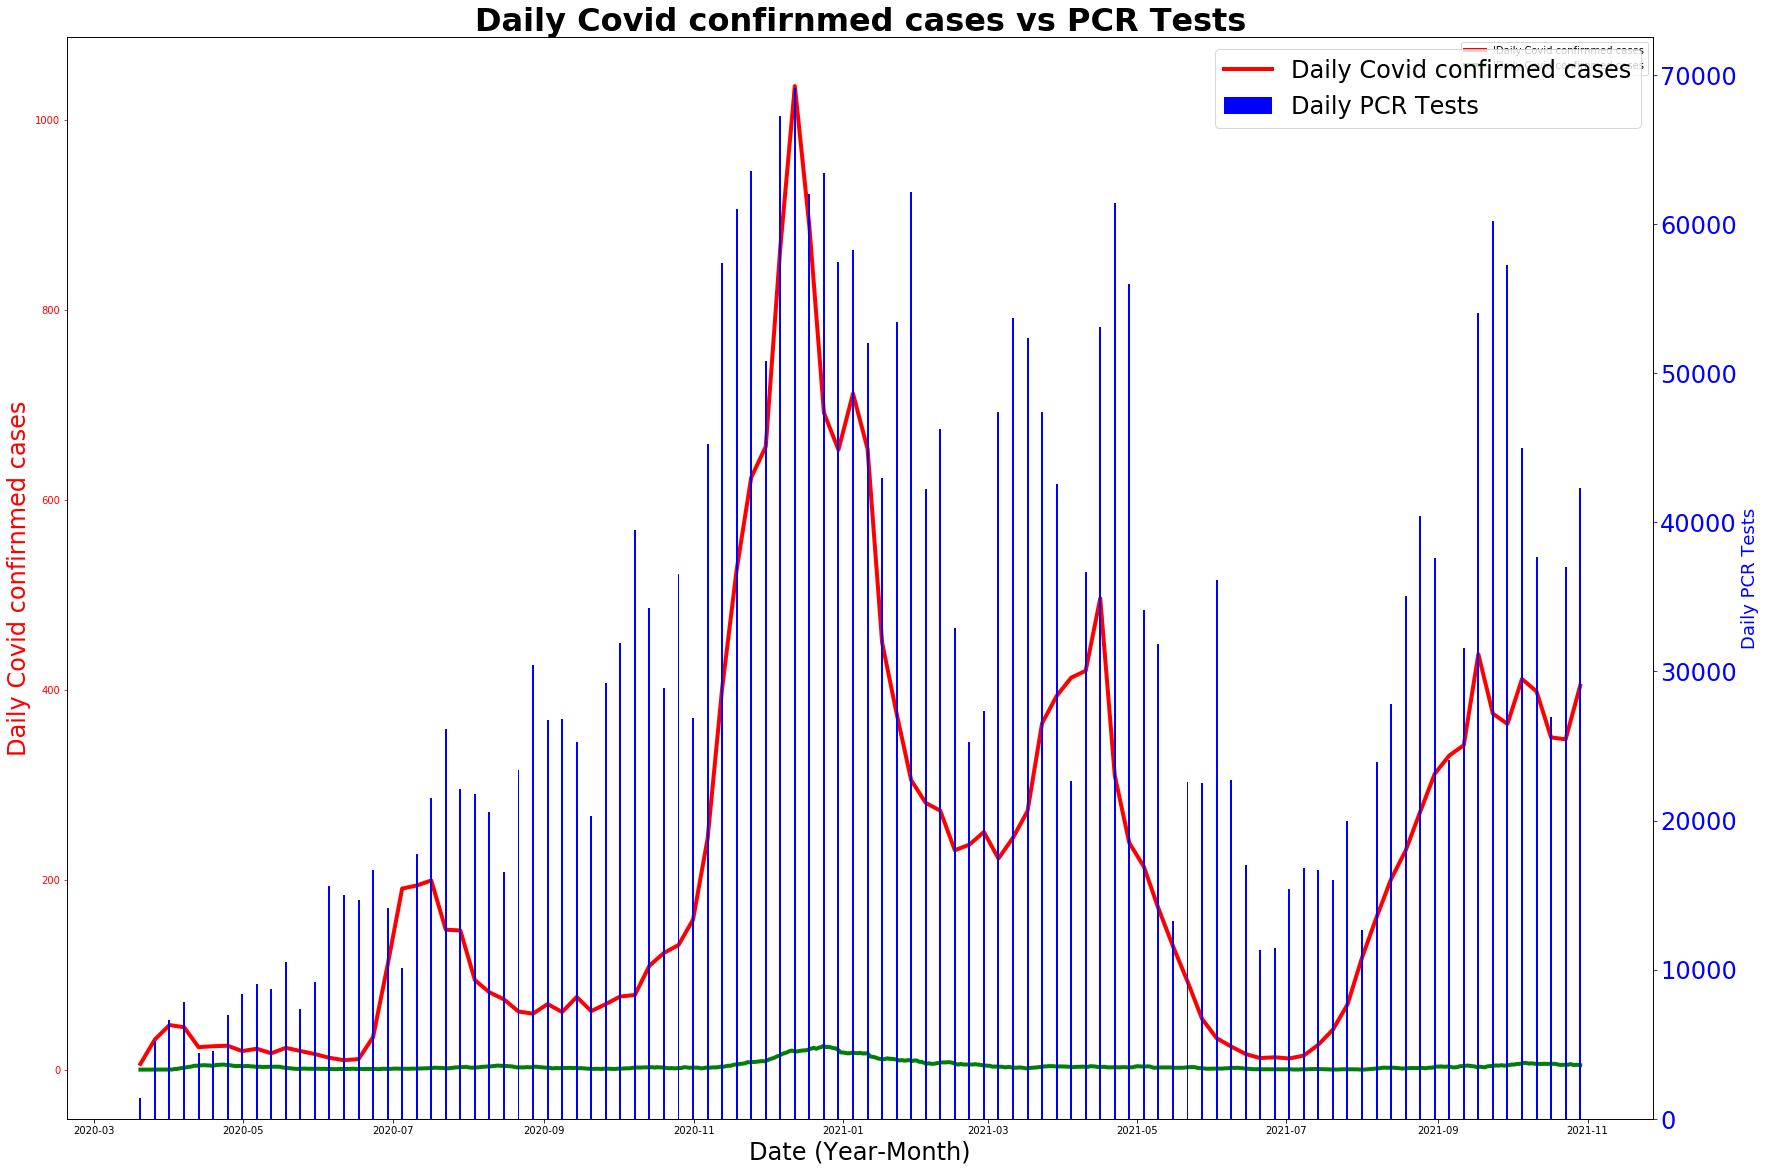

In [31]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pytz
from datetime import datetime

fig, ax1 = plt.subplots(1,1,figsize=(24,16))

date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['DailyCases_7DayMovingAvg'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)
p1, = ax1.plot(date_num_smooth2, value_np_smooth,label= "'Daily Covid confirnmed cases", color = "r",linewidth=4.0)
p3, = ax1.plot(df_final['date'], df_final['Deaths_7DayMovingAvg'],label= "'Daily Covid confirnmed cases", color = "g",linewidth=4.0)



ax1.set_xlabel("Date (Year-Month)",fontsize=24)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Daily Covid confirnmed cases', color='r', fontsize=24)
ax1.tick_params('y', colors='r') 

ax1.legend(loc="upper right")
#create data
date_np = np.array(list(df_final['date']))
value_np = np.array(list(df_final['New PCR Tests'] ))
date_num = dates.date2num(date_np)
# smooth
date_num_smooth = np.linspace(date_num.min(), date_num.max(), 100) 
spl = make_interp_spline(date_num, value_np, k=3)
value_np_smooth = spl(date_num_smooth)

tz = pytz.timezone('UTC')
date_num_smooth2 = dates.num2date(date_num_smooth,tz=tz)

ax2 = ax1.twinx()
p2 = ax2.bar(date_num_smooth2, value_np_smooth, label= "PCR Tests",color = "b")
ax2.set_ylabel('Daily PCR Tests', color='b',fontsize=18)
ax2.tick_params('y', colors='b')
ax2.legend(loc="upper right")

fig.tight_layout()
plt.xticks(rotation=45,ha='right',fontsize=24)
plt.yticks(fontsize=24)
plt.title("Daily Covid confirnmed cases vs PCR Tests",fontweight="bold",fontsize=32)
plt.xlabel("Date (Year-Month)",fontsize=24)
plt.legend([p1,p2],["Daily Covid confirmed cases", "Daily PCR Tests"],fontsize=24)
plt.show()

There is no significant death volume increase for this county, but there might be increasein overall country.

Lets look at regression using xgboost algorithm

In [32]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 


Training score:  0.9771062503223461
MSE: 28647.61
RMSE: 169.26


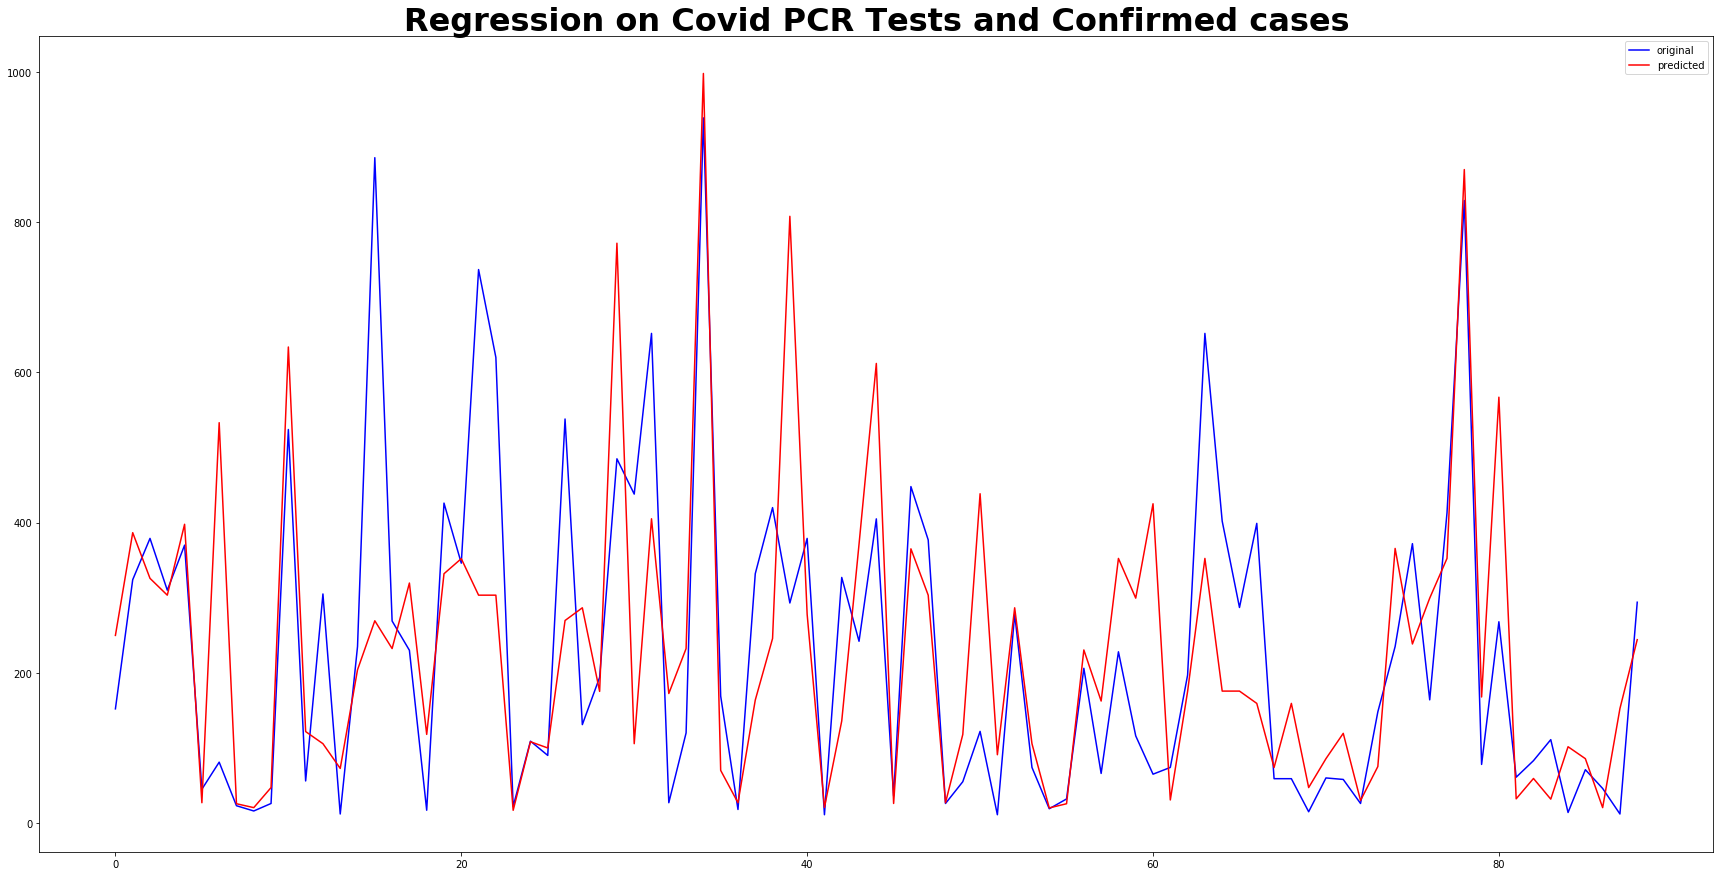

In [33]:
x= df_final[['New PCR Tests']]
y = df_final['DailyCases_7DayMovingAvg']

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(xtrain, ytrain)
score = xgbr.score(xtrain, ytrain)   
print("Training score: ", score) 
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

x_ax = range(len(ytest))
plt.figure(figsize=(30,15))
plt.plot(x_ax, ytest,  color="blue", label="original")
plt.plot(x_ax, ypred,  color="red", label="predicted")

plt.title("Regression on Covid PCR Tests and Confirmed cases",fontweight="bold",fontsize=32)

plt.legend()
plt.show()

Training score:  0.6528149568334223
MSE: 0.00
RMSE: 0.00


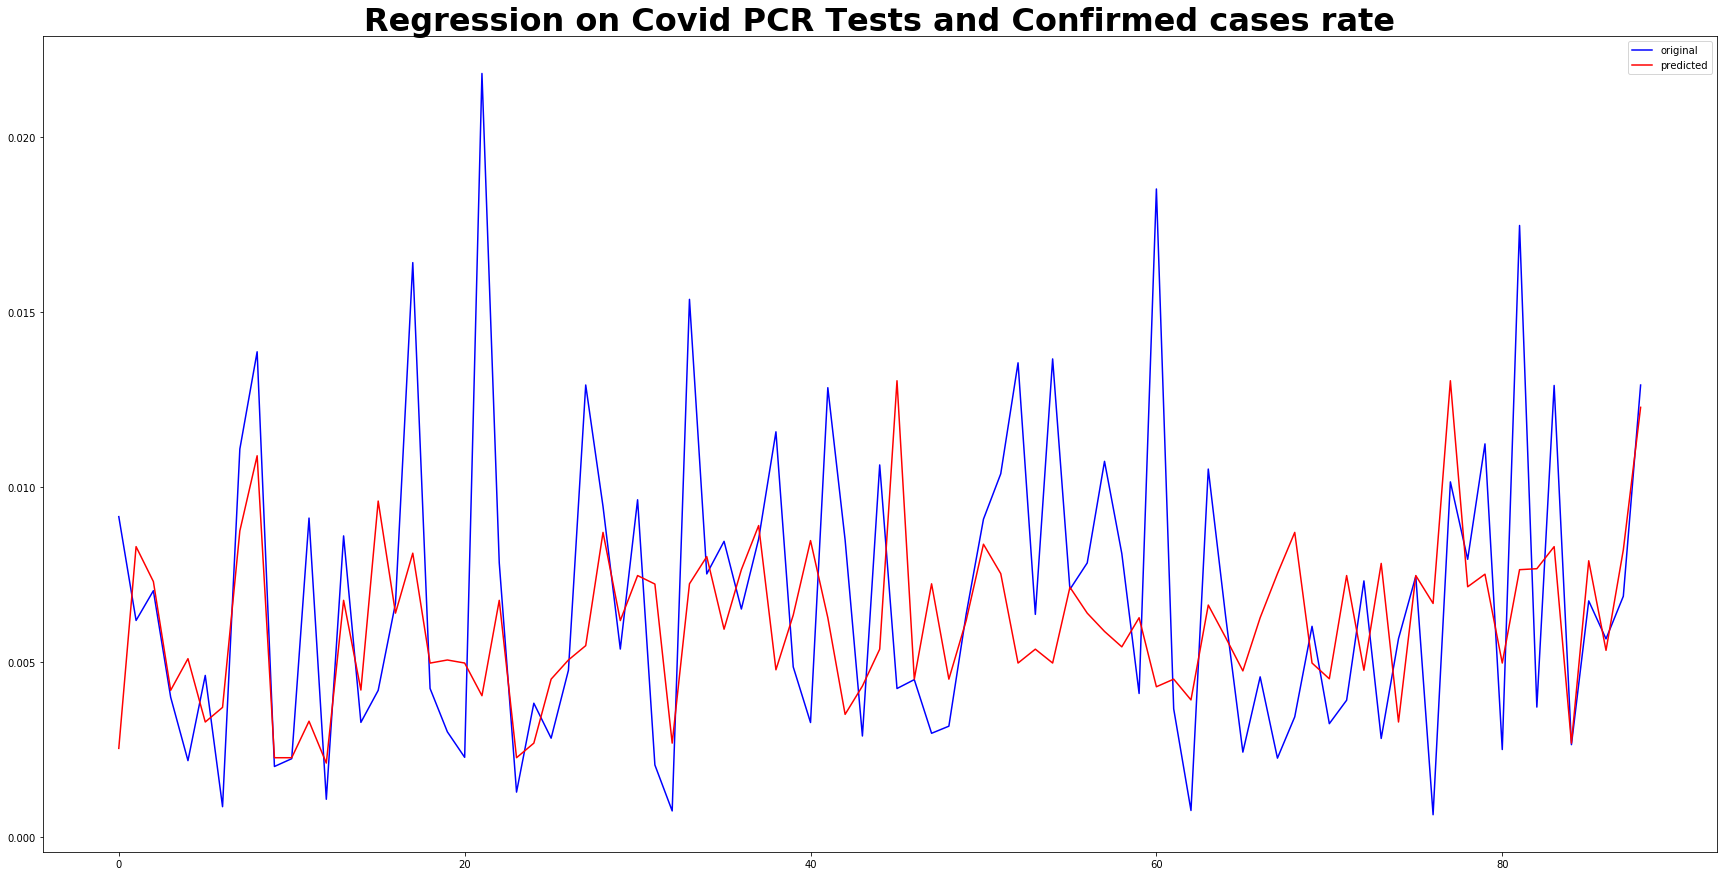

In [34]:
x= df_final[['New PCR Tests']]
y = df_final['ConfirmedCaseRate']

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(xtrain, ytrain)
score = xgbr.score(xtrain, ytrain)   
print("Training score: ", score) 
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

x_ax = range(len(ytest))
plt.figure(figsize=(30,15))
plt.plot(x_ax, ytest,  color="blue", label="original")
plt.plot(x_ax, ypred,  color="red", label="predicted")
plt.legend()
plt.title("Regression on Covid PCR Tests and Confirmed cases rate",fontweight="bold",fontsize=32)

plt.show()

Above regression plots shows prediction and actual values between PCRTests and confirmed cases and Rate.